# <span style="color:orange"> *Multiple bounded optimization* </span> 

In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

 # <span style="color:lime"> *Repository & Tool loading* </span> 

In [2]:
%cd susceptibility-to-fieldmap-fft 
!git status
%pip install .

c:\Users\User\msc_project\sus-optimization\susceptibility-to-fieldmap-fft


c:\Users\User\miniconda3\envs\chi_opt\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


HEAD detached at d9f785b
nothing to commit, working tree clean
Processing c:\users\user\msc_project\sus-optimization\susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for susceptibility-to-fieldmap-fft: filename=susceptibility_to_fieldmap_fft-0.0.0-py3-none-any.whl size=23545 sha256=0d2d2fe7a9749d35c4d4b98954ea53b23baf316055d8c648d419c98550a4815e
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\17\ea\51\22427b7b5d1aced006c3db69245d8a8f88effcb4349a030d61
Successfully built susceptibility-to-fieldmap-fft
  Attempting uninstall: susceptibility-to-fieldmap-fft
    Found existing installation: susceptibility-to-fieldmap-fft 0.0.0
    Uninstalling susceptibility-to-fieldmap-fft-0.0.0:
      Successfully uninstalled susceptibility-to-fieldmap-fft-0.0.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
home_path = "C:/Users/User/msc_project/sus-optimization"
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\User\msc_project\sus-optimization


c:\Users\User\miniconda3\envs\chi_opt\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


README.md
__pycache__
chi_calculator.ipynb
chi_opt_pro.ipynb
data
evas_code.ipynb
fixed_chi_test.ipynb
internal_air_only.nii.gz
output
requirements.txt
simulation
soothsayer.ipynb
spinal_cord_voxels_only.nii.gz
sus_optimization.ipynb
susceptibility-to-fieldmap-fft
tissue-to-MRproperty
utils


In [2]:
path_to_chi_to_fm_fft = "C:/Users/User/msc_project/susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

## <span style="color:lime"> *Util functions used during the optimization process* </span> 

In [4]:
# We need to reate the custom command that creates the fieldmap
def chi_to_fm_ppm(input_file, output_file):

    #Using a custom command for dB0 simulation

    command = [
    "compute_fieldmap",
    "-i", input_file,
    "-o", output_file,
    "-b", "50",
    "-m", "b0SimISMRM"
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True)

    # We need to return the data from the fieldmap created

    
    # Check for errors
    if result.returncode != 0:
        print("Error occurred:", result.stderr)

    else:
        print("Fieldmap simulated correctly", result.stdout)
        sim_fm_img = nib.load(output_file)
        sim_fm_data = sim_fm_img.get_fdata()
        return sim_fm_data

In [5]:
# Function to automate the subprocess of extractiing measure with SCT through the terminal
from utils.extract_metric import extract_metrics
# Example of calling the function:
#extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_metric_mask, out_B0_metrics_path, method='wa', vert="3:15") # Change numbers x:y accordingly

In [6]:
from utils.tools import chi_to_fm_ppm

 # <span style="color:gold"> *Optimization begins!* </span> 

In [7]:
# First lets define the paths for simulation files
# Change run # to avoid mix of outputs per different optimization approach
path_to_iter_dmod_fms =  "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16"
path_to_iter_metrics =  "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16"
counter = 0

########
# This don't change
path_to_sim_metric_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap = "E:/msc_data/ismrm_2025/db0_032/fm/sim/B1_chi_maps/db0_032_sus_opt_map.nii.gz" # -4.36 (past value)
path_to_segs = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/grouped_wb_segs.nii.gz"

In [8]:
# Now load the measured values (done 1 time outside of loop, this values are the reference)
b0meas_metrics = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/C_dmod_meas/exp/exp_metrics.csv")
dmod_b0meas_vert_values = b0meas_metrics["WA()"]
dmod_b0meas_vert_values = dmod_b0meas_vert_values[::-1]
dmod_b0meas_vert_values

12   -133.966738
11   -121.118786
10    -80.314337
9      -8.943227
8      55.167182
7      39.844835
6     -12.995903
5      -8.459881
4      22.489457
3      56.544607
2      63.354887
1      41.714478
0      19.229226
Name: WA(), dtype: float64

In [9]:
avg_resp_b0meas_metrics_csv = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/C_dmod_meas/simple_avg_respiration.csv")
avg_resp_b0meas_values = avg_resp_b0meas_metrics_csv["WA()"]
avg_resp_b0meas_values

0    -120.366184
1    -100.056767
2     -42.013446
3      43.314191
4     104.134758
5      67.827829
6     -12.573064
7     -30.862036
8     -10.427612
9      17.335520
10     25.933529
11     15.269733
12     -3.524973
Name: WA(), dtype: float64

In [63]:
def f_max(x):

    global counter # This works?
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Current values of variables: x[0] = {x[0]} & x[1] = {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    ind_body = np.where((ROI_data == 2))
    ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    sim_chi_data[ind_trachea] = x[0]
    sim_chi_data[ind_lungs] = x[1]
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi1 = x[0]
    chi2 = x[1]
    #chi3 = x[2]

    chi1_name = str(str(float(f"{chi1:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi2:.3f}"))).replace(".","_")
    #chi3_name = str(str(float(f"{chi3:.3f}"))).replace(".","_")

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving ... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()']
    dmod_sim_vert_values = dmod_sim_vert_values[::-1]

    difference = np.linalg.norm(dmod_b0meas_vert_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    return difference
    


In [131]:
def f_max_avg_resp(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Current values of variables: x[0] = {x[0]} & x[1] = {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    ind_body = np.where((ROI_data == 2))
    ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    sim_chi_data[ind_trachea] = x[0]
    sim_chi_data[ind_lungs] = x[1]
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi1 = x[0]
    chi2 = x[1]
    #chi3 = x[2]

    chi1_name = str(str(float(f"{chi1:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi2:.3f}"))).replace(".","_")
    #chi3_name = str(str(float(f"{chi3:.3f}"))).replace(".","_")

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving ... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()']
    dmod_sim_vert_values = dmod_sim_vert_values[::-1]

    difference = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    return difference

In [45]:
def f_max_avg_resp_plot(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Current values of variables: x[0] = {x[0]} & x[1] = {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    ind_body = np.where((ROI_data == 2))
    ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    sim_chi_data[ind_trachea] = x[0]
    sim_chi_data[ind_lungs] = x[1]
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi1 = x[0]
    chi2 = x[1]
    #chi3 = x[2]
    
    chi1_name = str(str(float(f"{chi1:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi2:.3f}"))).replace(".","_")
    #chi3_name = str(str(float(f"{chi3:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run13"
    chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving ... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()'][::-1]

    difference = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8']

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = f"Run9 iter: {counter}", color = "#EF9A9A")  
    plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 
    plt.title(f"Sim vs Avg $\\chi$ tr: {chi1} & l: {chi2}")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-250, 101, 20) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()


    return difference

In [10]:
def f_iair_avg_resp_plot(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Chi air : x[0] = {x[0]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    #ind_body = np.where((ROI_data == 2))
    #ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    # Now we get only 1 value 
    chi_trachea = 0.1*(-9) + 0.9*(x[0])
    chi_lungs = 0.2*(-9) + 0.8*(x[0])

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi_air = x[0]
    #chi3 = x[2]
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    chi_3_name = str(str(float(f"{chi_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving dmod FM... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()'][::-1]

    difference = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8']

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = f"Run14 iter: {counter}", color = "#EF9A9A")  
    plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 
    plt.title(f"Sim vs Avg $\\chi$ tr: {chi1_name} & l: {chi2_name} & air: {chi_3_name}")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-250, 101, 20) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()


    return difference

In [11]:
def f_iair_vol_avg_resp_plot(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Chi air : x[0] = {x[0]}")
    print(f"Vol_air Tr: ", x[1])
    print(f"Vol_air_lungs: ", x[2])
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    #ind_body = np.where((ROI_data == 2))
    #ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    # Now we get only 1 value 
    chi_trachea = (1-x[1])*(-9) + (x[1])*(x[0])
    chi_lungs = (1-x[2])*(-9) + (x[2])*(x[0])

    sim_chi_data[ind_trachea] = chi_trachea
    sim_chi_data[ind_lungs] = chi_lungs
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi_air = x[0]
    #chi3 = x[2]
    
    chi1_name = str(str(float(f"{chi_trachea:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi_lungs:.3f}"))).replace(".","_")
    chi_3_name = str(str(float(f"{chi_air:.3f}"))).replace(".","_")

    # Just in case you want to check the chimaps created: ###################################
    chi_map_name = f"chimap_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz"
    # Load where you want to save them, and dont forget to use the same run number :)
    # And don't forget to actually create the run# folder 
    path_to_iterchimaps = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/chimaps_extra/run14"
    chimap_img = nib.Nifti1Image(sim_chi_data, affine = sim_chi_img.affine)
    chimap_save_dir = os.path.join(path_to_iterchimaps, chi_map_name)
    nib.save(chimap_img, chimap_save_dir)
    ##########################################################################################

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving dmod FM... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_air_{chi_3_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()'][::-1]

    difference = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8']

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = f"Run16 iter: {counter}", color = "#EF9A9A")  
    plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 
    plt.title(f"Sim vs Avg $\\chi$ tr: {chi1_name} & l: {chi2_name} & air: {chi_3_name}")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-250, 101, 20) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()


    return difference

In [19]:
# Before running please verify your outpaths:
print(path_to_iter_dmod_fms)
print(path_to_iter_metrics)


E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run15
E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run15


In [20]:
# Reset counter if neceesary (alone verrsion)
# This should be done when defining new paths but sometimes can be overridden
# Use with care
counter


1

In [21]:
counter = 0
counter

0

 ### <span style="color:lime"> *Chi trachea and Chi lung optimization* </span> 

################
Iteration #1
Current values of variables: x[0] = 1.0 & x[1] = 0.0
Demod value for Simulation:  -281.6524510191614
Saving ...  dmod_sim_fm_tr_1_0_l_0_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run13\dmod_sim_fm_tr_1_0_l_0_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_0_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_0_0_Hz.csv


Minimizing difference:  411.66910673135845


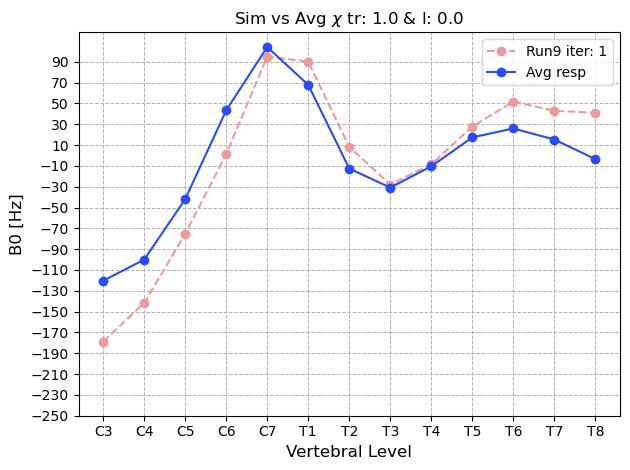

################
Iteration #2
Current values of variables: x[0] = 1.05 & x[1] = 0.0
Demod value for Simulation:  -281.6481936705928
Saving ...  dmod_sim_fm_tr_1_05_l_0_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run13\dmod_sim_fm_tr_1_05_l_0_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_05_l_0_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_05_l_0_0_Hz.csv


Minimizing difference:  411.69549721016995


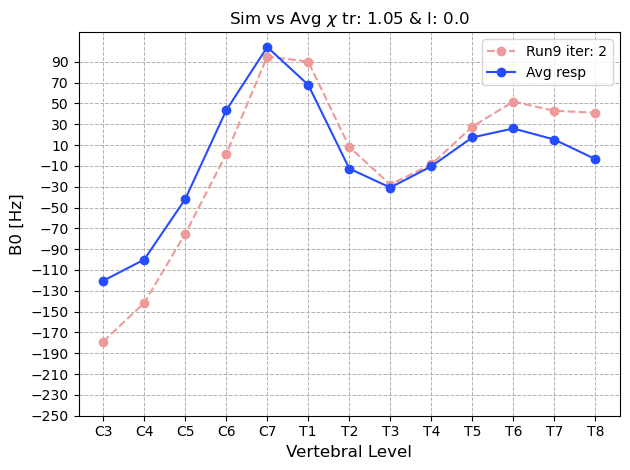

################
Iteration #3
Current values of variables: x[0] = 1.0 & x[1] = -0.00025
Demod value for Simulation:  -281.65180295793107
Saving ...  dmod_sim_fm_tr_1_0_l_-0_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run13\dmod_sim_fm_tr_1_0_l_-0_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_-0_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_-0_0_Hz.csv


Minimizing difference:  411.67086995948205


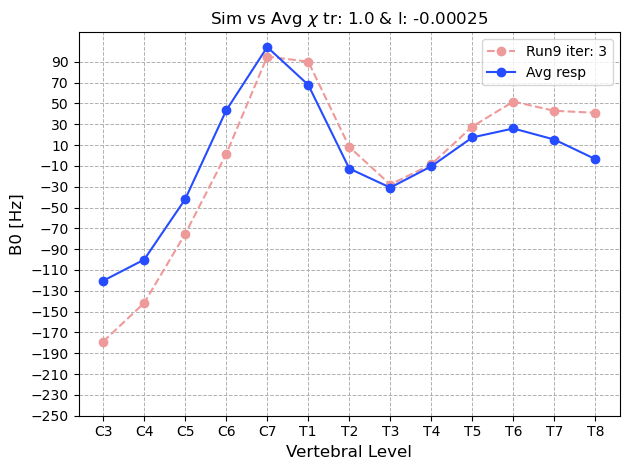

################
Iteration #4
Current values of variables: x[0] = 1.0 & x[1] = -0.00025
Demod value for Simulation:  -281.65180295793107
Saving ...  dmod_sim_fm_tr_1_0_l_-0_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run13\dmod_sim_fm_tr_1_0_l_-0_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_-0_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_-0_0_Hz.csv


Minimizing difference:  411.67086995948205


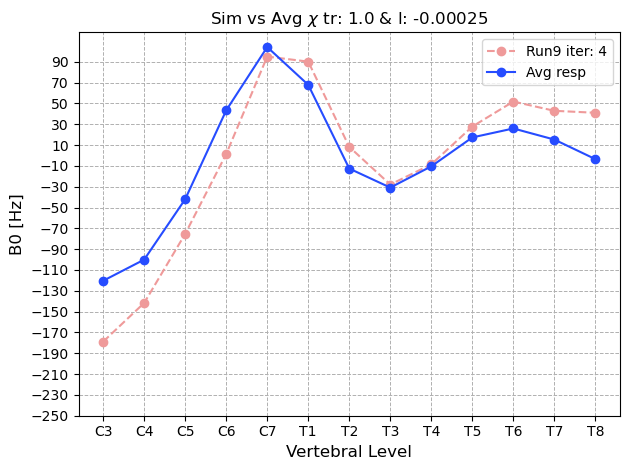

################
Iteration #5
Current values of variables: x[0] = 1.0 & x[1] = -0.0001875
Demod value for Simulation:  -281.65196497323865
Saving ...  dmod_sim_fm_tr_1_0_l_-0_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run13\dmod_sim_fm_tr_1_0_l_-0_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_-0_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_-0_0_Hz.csv


Minimizing difference:  411.6704291231073


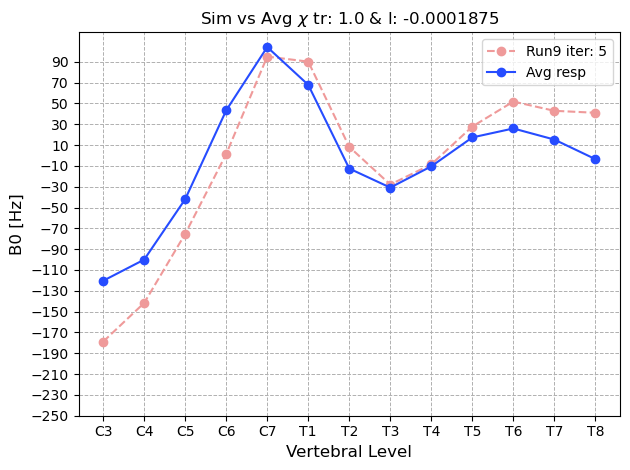

################
Iteration #6
Current values of variables: x[0] = 1.0 & x[1] = 0.0
Demod value for Simulation:  -281.6524510191614
Saving ...  dmod_sim_fm_tr_1_0_l_0_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run13\dmod_sim_fm_tr_1_0_l_0_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_0_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_0_0_Hz.csv


Minimizing difference:  411.66910673135845


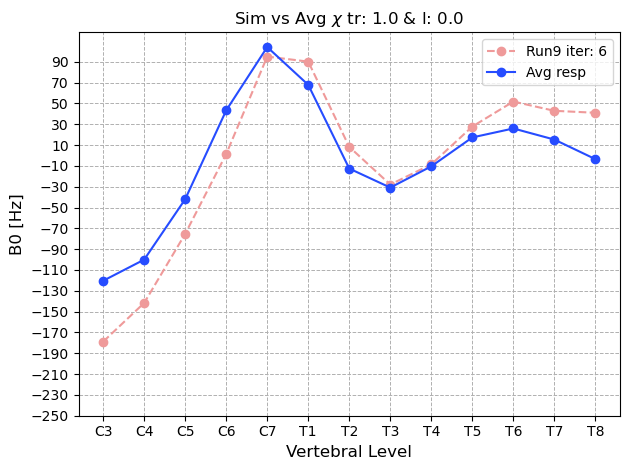

################
Iteration #7
Current values of variables: x[0] = 1.0 & x[1] = 0.0
Demod value for Simulation:  -281.6524510191614
Saving ...  dmod_sim_fm_tr_1_0_l_0_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run13\dmod_sim_fm_tr_1_0_l_0_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_0_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_0_0_Hz.csv


Minimizing difference:  411.66910673135845


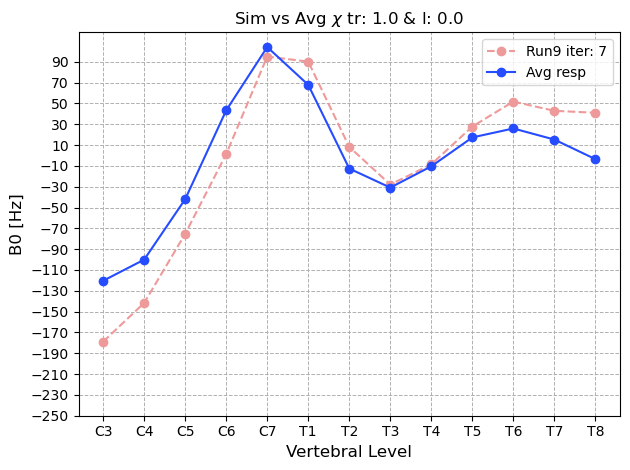

################
Iteration #8
Current values of variables: x[0] = 1.0 & x[1] = 0.0
Demod value for Simulation:  -281.6524510191614
Saving ...  dmod_sim_fm_tr_1_0_l_0_0_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run13\dmod_sim_fm_tr_1_0_l_0_0_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_0_0_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run13\metrics_sim_fm_tr_1_0_l_0_0_Hz.csv


Minimizing difference:  411.66910673135845


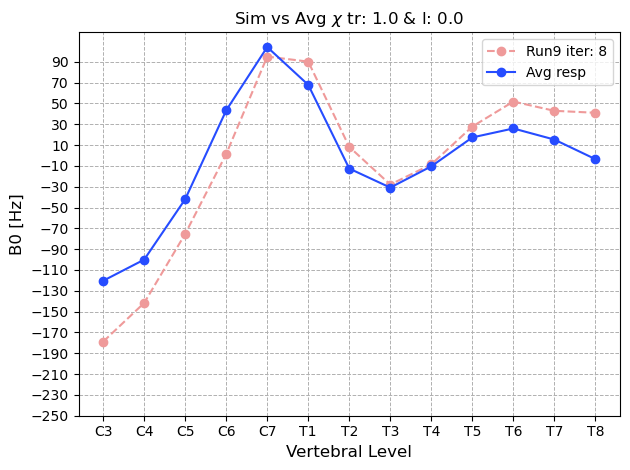

Optimization result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 411.66910673135845
             x: [ 1.000e+00  0.000e+00]
           nit: 4
          nfev: 8
 final_simplex: (array([[ 1.000e+00,  0.000e+00],
                       [ 1.000e+00,  0.000e+00],
                       [ 1.000e+00,  0.000e+00]]), array([ 4.117e+02,  4.117e+02,  4.117e+02]))


In [49]:
# Set initial values, boundaries and run optimization
initial_values = [-1, 0] # Body should begin
# First bound is trachea
# Second bound is Lung
bounds = [(-1.5, 1), (-9, 0)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    if not os.path.exists(path_to_iter_dmod_fms) or not os.path.exists(path_to_iter_metrics):
        print("Creating run folders")
        os.makedirs(path_to_iter_dmod_fms)
        os.makedirs(path_to_iter_metrics)
        print("Folders created: ", path_to_iter_dmod_fms)
    
    result = optimize.minimize(f_max_avg_resp_plot, initial_values, bounds = bounds, method = 'Nelder-Mead')

    # Output the result
    print("Optimization result:", result)


 ### <span style="color:gold"> *Chi internal air!* </span> 

Creating run folders
Folders created:  E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16
################
Iteration #1
Chi air : x[0] = 0.3
Vol_air Tr:  0.9
Vol_air_lungs:  0.8
Demod value for Simulation:  -277.7473385058717
Saving dmod FM...  dmod_sim_fm_tr_-0_63_l_-1_56_air_0_3_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_63_l_-1_56_air_0_3_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_63_l_-1_56_air_0_3_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_63_l_-1_56_air_0_

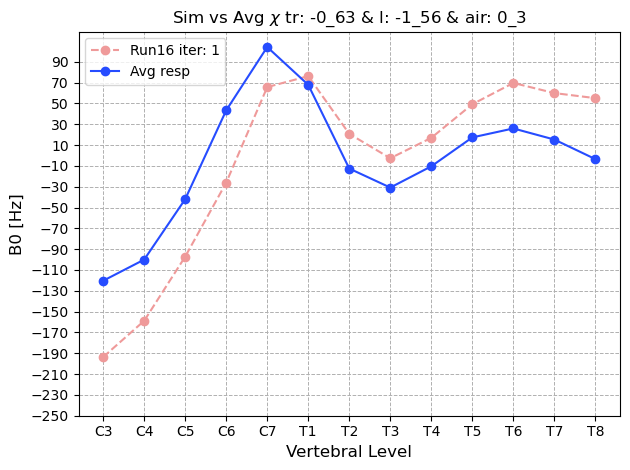

################
Iteration #2
Chi air : x[0] = 0.315
Vol_air Tr:  0.9
Vol_air_lungs:  0.8
Demod value for Simulation:  -277.7772959608091
Saving dmod FM...  dmod_sim_fm_tr_-0_616_l_-1_548_air_0_315_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_616_l_-1_548_air_0_315_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_616_l_-1_548_air_0_315_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_616_l_-1_548_air_0_315_Hz.csv


Minimizing difference:  427.9969277158579


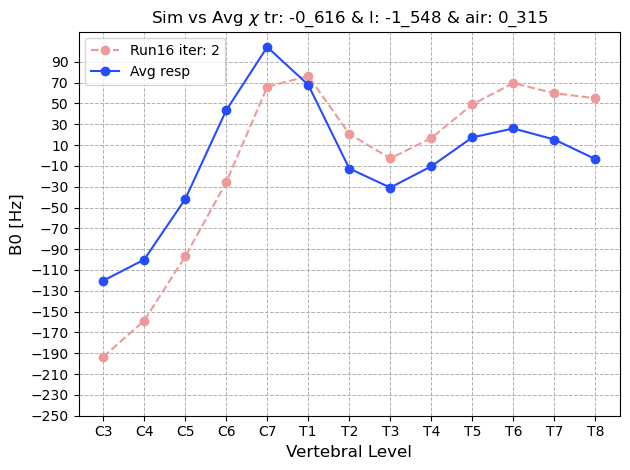

################
Iteration #3
Chi air : x[0] = 0.3
Vol_air Tr:  0.855
Vol_air_lungs:  0.8
Demod value for Simulation:  -277.7829725133906
Saving dmod FM...  dmod_sim_fm_tr_-1_049_l_-1_56_air_0_3_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-1_049_l_-1_56_air_0_3_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_049_l_-1_56_air_0_3_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_049_l_-1_56_air_0_3_Hz.csv


Minimizing difference:  428.0747427425348


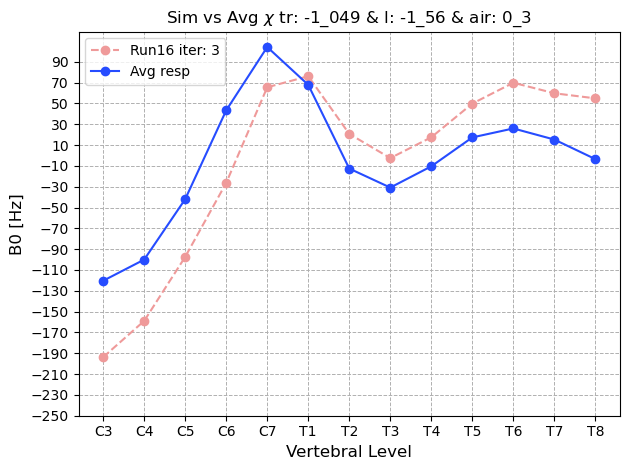

################
Iteration #4
Chi air : x[0] = 0.3
Vol_air Tr:  0.9
Vol_air_lungs:  0.8400000000000001
Demod value for Simulation:  -278.71165361645143
Saving dmod FM...  dmod_sim_fm_tr_-0_63_l_-1_188_air_0_3_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_63_l_-1_188_air_0_3_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_63_l_-1_188_air_0_3_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_63_l_-1_188_air_0_3_Hz.csv


Minimizing difference:  422.9974788460452


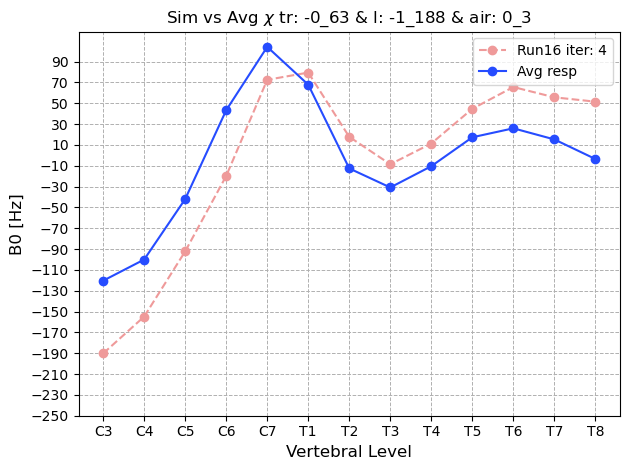

################
Iteration #5
Chi air : x[0] = 0.31
Vol_air Tr:  0.8700000000000002
Vol_air_lungs:  0.8266666666666669
Demod value for Simulation:  -278.4346596972994
Saving dmod FM...  dmod_sim_fm_tr_-0_9_l_-1_304_air_0_31_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_9_l_-1_304_air_0_31_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_9_l_-1_304_air_0_31_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_9_l_-1_304_air_0_31_Hz.csv


Minimizing difference:  424.46590412054894


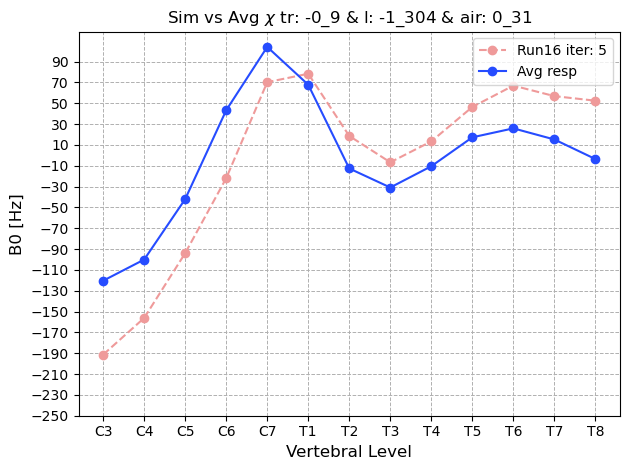

################
Iteration #6
Chi air : x[0] = 0.3166666666666667
Vol_air Tr:  0.9
Vol_air_lungs:  0.8444444444444446
Demod value for Simulation:  -278.85400598231377
Saving dmod FM...  dmod_sim_fm_tr_-0_615_l_-1_133_air_0_317_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_615_l_-1_133_air_0_317_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_615_l_-1_133_air_0_317_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_615_l_-1_133_air_0_317_Hz.csv


Minimizing difference:  422.2853728247805


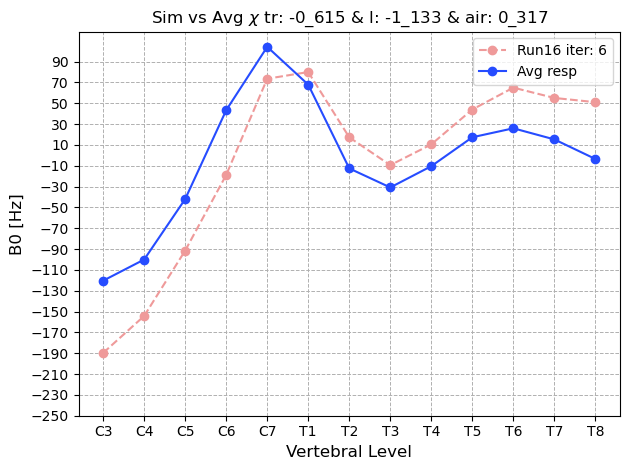

################
Iteration #7
Chi air : x[0] = 0.32500000000000007
Vol_air Tr:  0.9
Vol_air_lungs:  0.8666666666666667
Demod value for Simulation:  -279.4087798566019
Saving dmod FM...  dmod_sim_fm_tr_-0_607_l_-0_918_air_0_325_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_607_l_-0_918_air_0_325_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_607_l_-0_918_air_0_325_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_607_l_-0_918_air_0_325_Hz.csv


Minimizing difference:  419.65096853644496


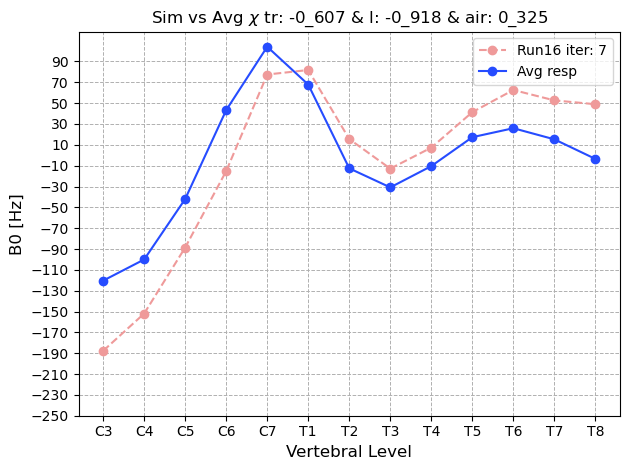

################
Iteration #8
Chi air : x[0] = 0.3083333333333334
Vol_air Tr:  0.8800000000000002
Vol_air_lungs:  0.8888888888888891
Demod value for Simulation:  -279.9246757136073
Saving dmod FM...  dmod_sim_fm_tr_-0_809_l_-0_726_air_0_308_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_809_l_-0_726_air_0_308_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_809_l_-0_726_air_0_308_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_809_l_-0_726_air_0_308_Hz.csv


Minimizing difference:  417.3

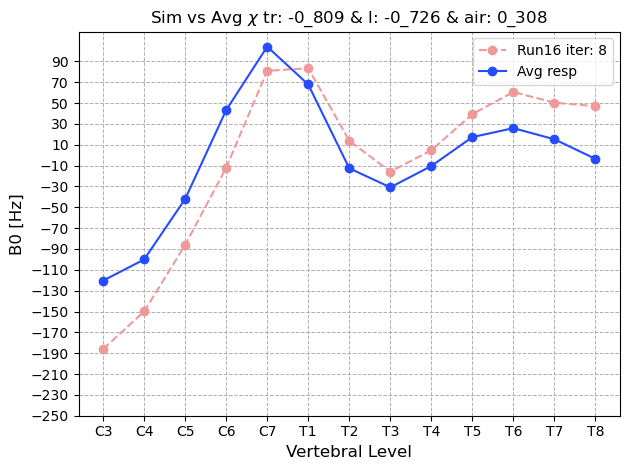

################
Iteration #9
Chi air : x[0] = 0.30500000000000005
Vol_air Tr:  0.8700000000000003
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.19317700015233
Saving dmod FM...  dmod_sim_fm_tr_-0_905_l_-0_625_air_0_305_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_905_l_-0_625_air_0_305_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_905_l_-0_625_air_0_305_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_905_l_-0_625_air_0_305_Hz.csv


Minimizing difference:  416.2803113839285


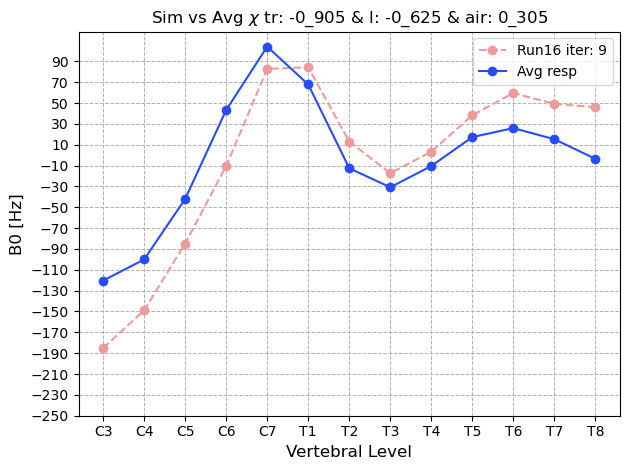

################
Iteration #10
Chi air : x[0] = 0.3100000000000001
Vol_air Tr:  0.9
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.180690163867
Saving dmod FM...  dmod_sim_fm_tr_-0_621_l_-0_621_air_0_31_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_621_l_-0_621_air_0_31_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_621_l_-0_621_air_0_31_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_621_l_-0_621_air_0_31_Hz.csv


Minimizing difference:  416.34481155047615


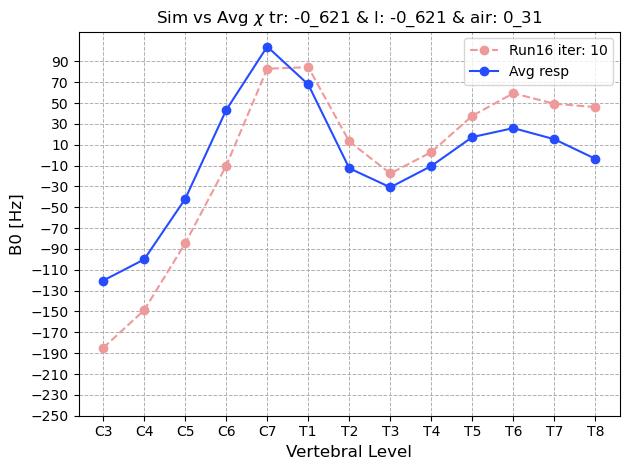

################
Iteration #11
Chi air : x[0] = 0.3266666666666668
Vol_air Tr:  0.8800000000000002
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.23417938150317
Saving dmod FM...  dmod_sim_fm_tr_-0_793_l_-0_606_air_0_327_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_793_l_-0_606_air_0_327_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_793_l_-0_606_air_0_327_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_793_l_-0_606_air_0_327_Hz.csv


Minimizing difference:  416.1214020551672


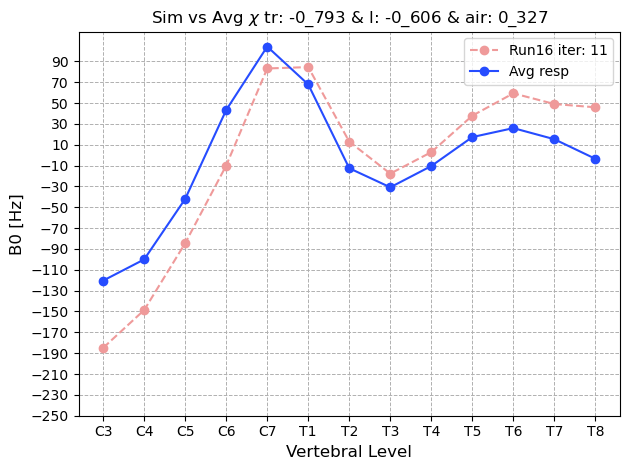

################
Iteration #12
Chi air : x[0] = 0.3400000000000002
Vol_air Tr:  0.8700000000000003
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.2722399898828
Saving dmod FM...  dmod_sim_fm_tr_-0_874_l_-0_594_air_0_34_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_874_l_-0_594_air_0_34_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_874_l_-0_594_air_0_34_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_874_l_-0_594_air_0_34_Hz.csv


Minimizing difference:  415.9650934760302


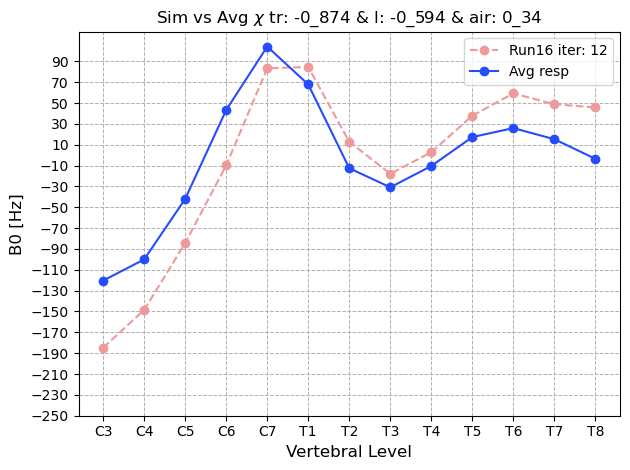

################
Iteration #13
Chi air : x[0] = 0.31166666666666676
Vol_air Tr:  0.8600000000000004
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.21616521939467
Saving dmod FM...  dmod_sim_fm_tr_-0_992_l_-0_619_air_0_312_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-0_992_l_-0_619_air_0_312_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_992_l_-0_619_air_0_312_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-0_992_l_-0_619_air_0_312_Hz.csv


Minimizing difference:  416.1834590286196

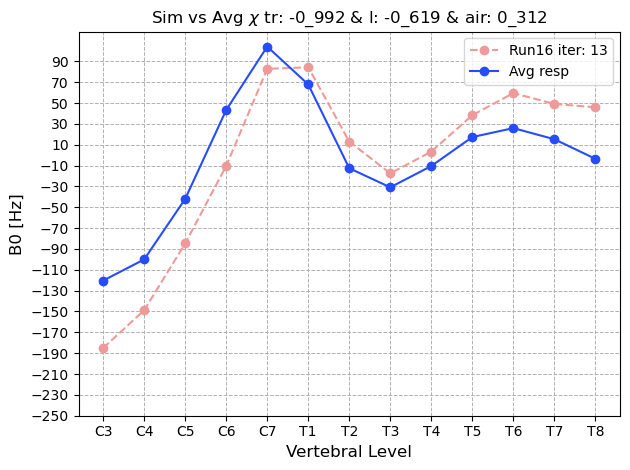

################
Iteration #14
Chi air : x[0] = 0.3277777777777779
Vol_air Tr:  0.8333333333333343
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.2737525328864
Saving dmod FM...  dmod_sim_fm_tr_-1_227_l_-0_605_air_0_328_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-1_227_l_-0_605_air_0_328_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_227_l_-0_605_air_0_328_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_227_l_-0_605_air_0_328_Hz.csv


Minimizing difference:  415.9404599351863


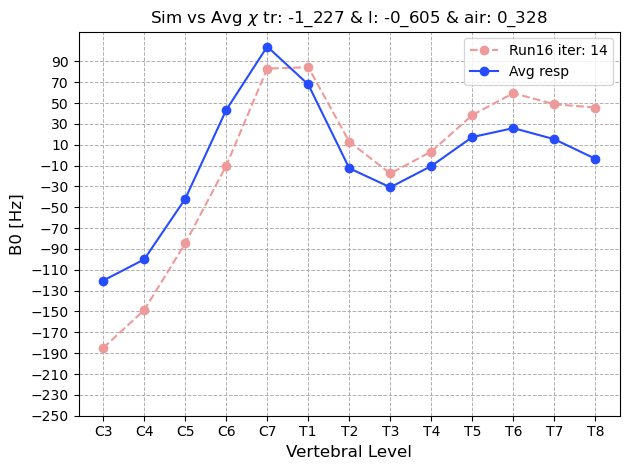

################
Iteration #15
Chi air : x[0] = 0.3366666666666668
Vol_air Tr:  0.8000000000000014
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.32035940359293
Saving dmod FM...  dmod_sim_fm_tr_-1_531_l_-0_597_air_0_337_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-1_531_l_-0_597_air_0_337_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_531_l_-0_597_air_0_337_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_531_l_-0_597_air_0_337_Hz.csv


Minimizing difference:  415.738961920825


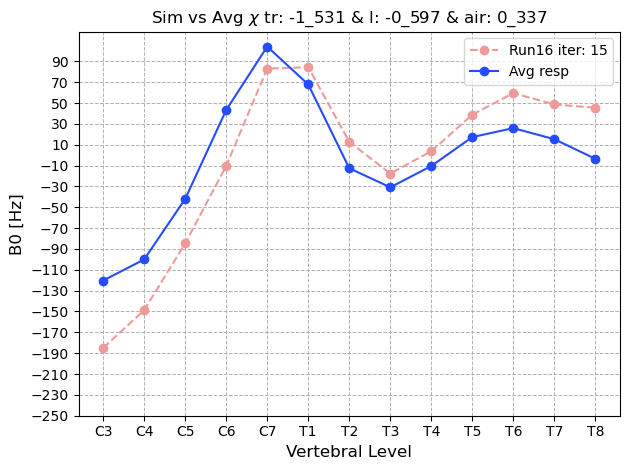

################
Iteration #16
Chi air : x[0] = 0.35388888888888914
Vol_air Tr:  0.8166666666666678
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.3460918086599
Saving dmod FM...  dmod_sim_fm_tr_-1_361_l_-0_581_air_0_354_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-1_361_l_-0_581_air_0_354_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_361_l_-0_581_air_0_354_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_361_l_-0_581_air_0_354_Hz.csv


Minimizing difference:  415.64408299688046

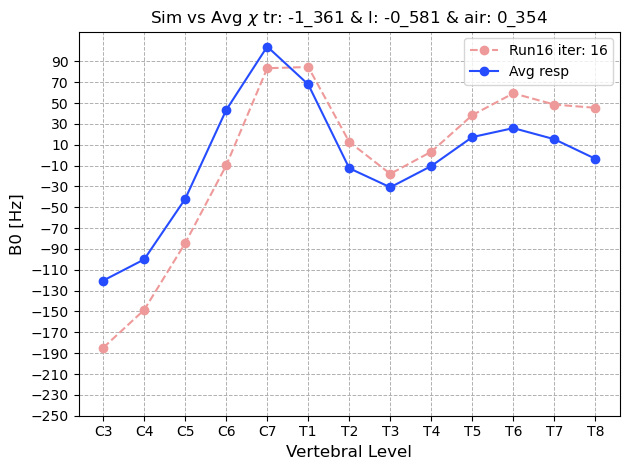

################
Iteration #17
Chi air : x[0] = 0.37833333333333363
Vol_air Tr:  0.7900000000000014
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.42271572254657
Saving dmod FM...  dmod_sim_fm_tr_-1_591_l_-0_559_air_0_378_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-1_591_l_-0_559_air_0_378_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_591_l_-0_559_air_0_378_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_591_l_-0_559_air_0_378_Hz.csv


Minimizing difference:  415.3270764570331

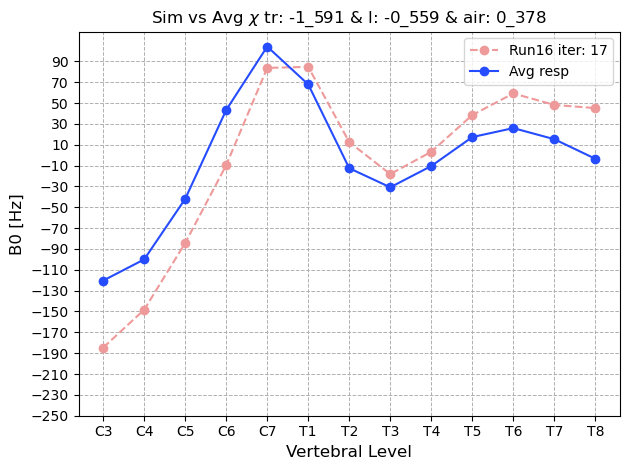

################
Iteration #18
Chi air : x[0] = 0.39166666666666694
Vol_air Tr:  0.7800000000000017
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.46092249989374
Saving dmod FM...  dmod_sim_fm_tr_-1_674_l_-0_547_air_0_392_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-1_674_l_-0_547_air_0_392_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_674_l_-0_547_air_0_392_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-1_674_l_-0_547_air_0_392_Hz.csv


Minimizing difference:  415.1712844890722

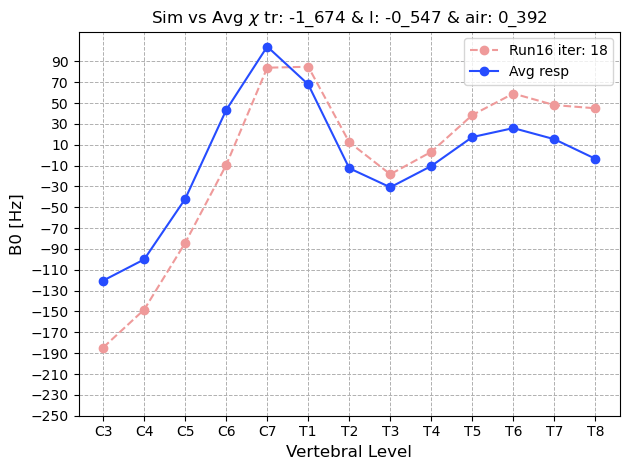

################
Iteration #19
Chi air : x[0] = 0.4316666666666671
Vol_air Tr:  0.7400000000000022
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.5837098456058
Saving dmod FM...  dmod_sim_fm_tr_-2_021_l_-0_511_air_0_432_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_021_l_-0_511_air_0_432_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_021_l_-0_511_air_0_432_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_021_l_-0_511_air_0_432_Hz.csv


Minimizing difference:  414.6684896099933


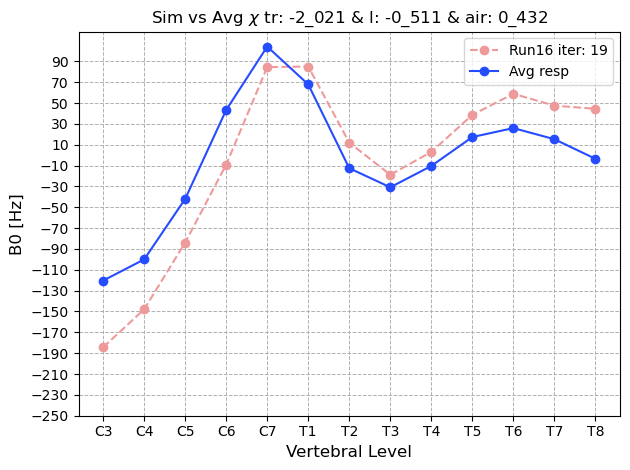

################
Iteration #20
Chi air : x[0] = 0.42444444444444474
Vol_air Tr:  0.7
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.59941383293005
Saving dmod FM...  dmod_sim_fm_tr_-2_403_l_-0_518_air_0_424_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_403_l_-0_518_air_0_424_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_403_l_-0_518_air_0_424_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_403_l_-0_518_air_0_424_Hz.csv


Minimizing difference:  414.5844381193837


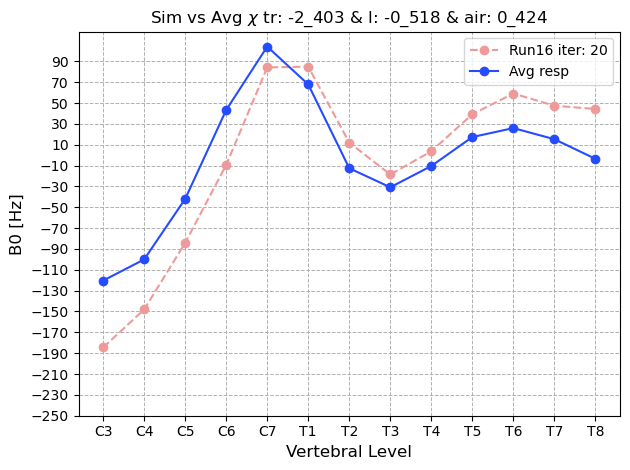

################
Iteration #21
Chi air : x[0] = 0.466666666666667
Vol_air Tr:  0.7
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.695402573882
Saving dmod FM...  dmod_sim_fm_tr_-2_373_l_-0_48_air_0_467_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_373_l_-0_48_air_0_467_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_373_l_-0_48_air_0_467_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_373_l_-0_48_air_0_467_Hz.csv


Minimizing difference:  414.21155063429916


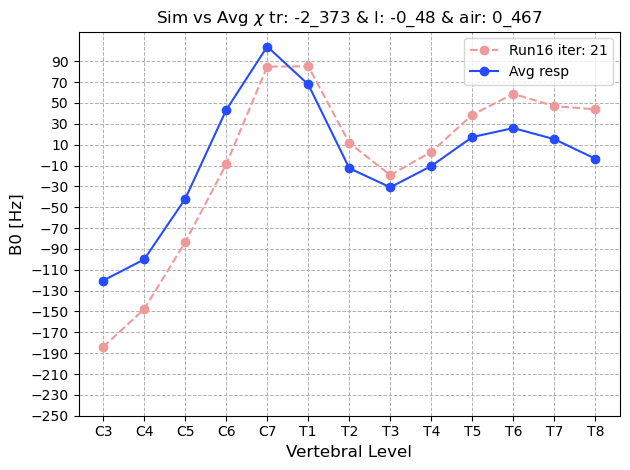

################
Iteration #22
Chi air : x[0] = 0.5
Vol_air Tr:  0.7
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.77118315884405
Saving dmod FM...  dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv


Minimizing difference:  413.9224074126888


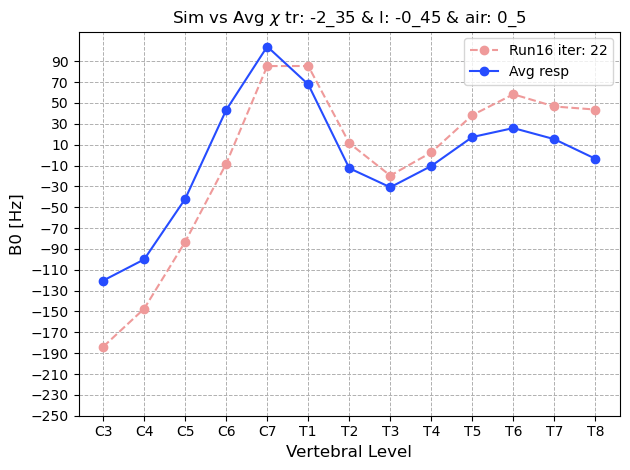

################
Iteration #23
Chi air : x[0] = 0.5
Vol_air Tr:  0.7
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.77118315884405
Saving dmod FM...  dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv


Minimizing difference:  413.9224074126888


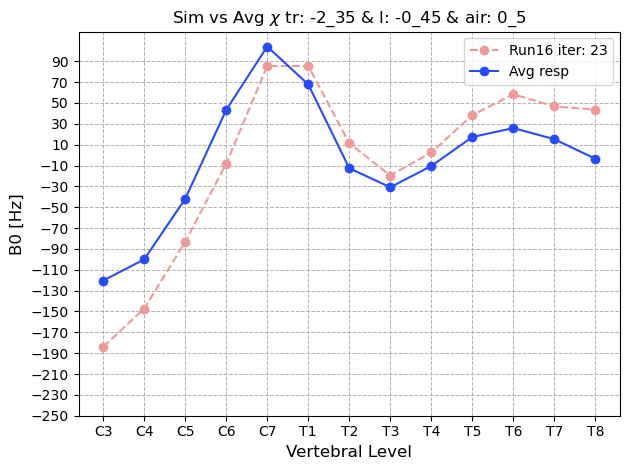

################
Iteration #24
Chi air : x[0] = 0.5
Vol_air Tr:  0.7
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.77118315884405
Saving dmod FM...  dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv


Minimizing difference:  413.9224074126888


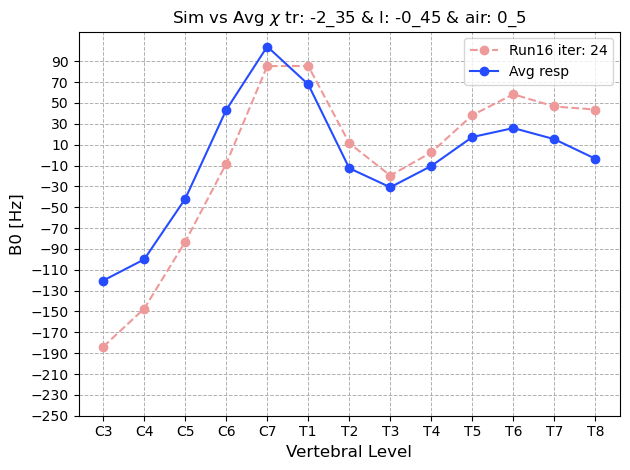

################
Iteration #25
Chi air : x[0] = 0.5
Vol_air Tr:  0.7
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.77118315884405
Saving dmod FM...  dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv


Minimizing difference:  413.9224074126888


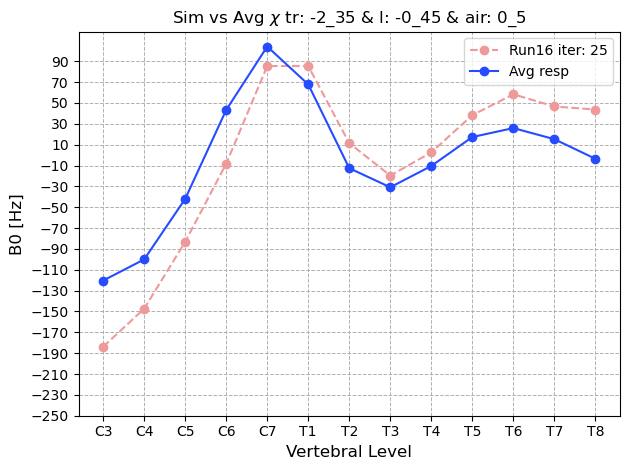

################
Iteration #26
Chi air : x[0] = 0.5
Vol_air Tr:  0.7
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.77118315884405
Saving dmod FM...  dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv


Minimizing difference:  413.9224074126888


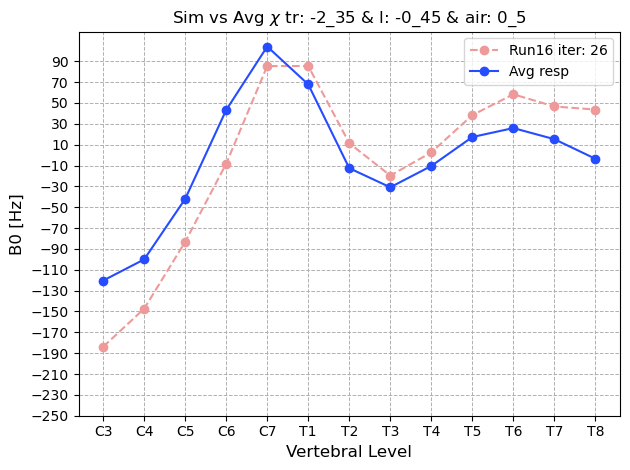

################
Iteration #27
Chi air : x[0] = 0.5
Vol_air Tr:  0.7
Vol_air_lungs:  0.9
Demod value for Simulation:  -280.77118315884405
Saving dmod FM...  dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/run16\dmod_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run16\metrics_sim_fm_tr_-2_35_l_-0_45_air_0_5_Hz.csv


Minimizing difference:  413.9224074126888


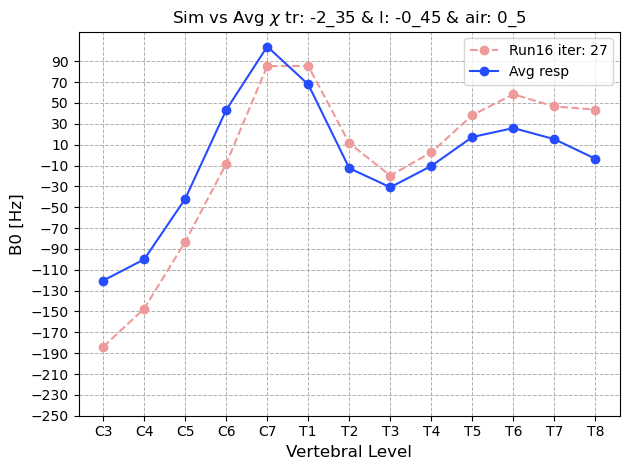

Optimization result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 413.9224074126888
             x: [ 5.000e-01  7.000e-01  9.000e-01]
           nit: 15
          nfev: 27
 final_simplex: (array([[ 5.000e-01,  7.000e-01,  9.000e-01],
                       [ 5.000e-01,  7.000e-01,  9.000e-01],
                       [ 5.000e-01,  7.000e-01,  9.000e-01],
                       [ 5.000e-01,  7.000e-01,  9.000e-01]]), array([ 4.139e+02,  4.139e+02,  4.139e+02,  4.139e+02]))


In [12]:
# Set initial values, boundaries and run optimization
initial_values = [0.3,0.9,0.8] # Body should begin
# First bound is trachea
# Second bound is Lung
bounds = [(-0.5, 0.5),(0.7,0.9),(0.6,0.9)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    if not os.path.exists(path_to_iter_dmod_fms) or not os.path.exists(path_to_iter_metrics):
        print("Creating run folders")
        os.makedirs(path_to_iter_dmod_fms)
        os.makedirs(path_to_iter_metrics)
        print("Folders created: ", path_to_iter_dmod_fms)
    
    result = optimize.minimize(f_iair_vol_avg_resp_plot, initial_values, bounds = bounds, method = 'Nelder-Mead')

    # Output the result
    print("Optimization result:", result)

In [89]:
os.path.exists(path_to_iter_dmod_fms)

True

# <span style="color:chocolate"> *Plot and compare!* </span> 

In [42]:
# Load specific metrics by name, from output log
run2_iter20 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run2/metrics_sim_fm_tr_-5_16_l_-0_389_Hz.csv")
run2_iter20_values = run2_iter20["WA()"]
run2_iter20_values = run2_iter20_values[::-1]

In [54]:
run4_last_iter = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run4/metrics_sim_fm_tr_-5_0_l_-0_575_Hz.csv")
run4_last_iter_vals = run4_last_iter["WA()"]
run4_last_iter_vals = run4_last_iter_vals[::-1]

In [70]:
# One with x lung far from that range
run6 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run6/metrics_sim_fm_tr_-2_0_l_1_0_Hz.csv")
run6_values = run6["WA()"][::-1]

In [106]:
run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7/metrics_sim_fm_tr_-2_0_l_0_0_Hz.csv")
run7_values = run7["WA()"][::-1]
run7_values

12   -179.632875
11   -142.424619
10    -76.976387
9      -0.345025
8      93.837069
7      89.462894
6       7.859834
5     -26.918593
4      -4.591906
3      32.335572
2      53.256685
1      41.671918
0      39.592175
Name: WA(), dtype: float64

In [107]:
first_run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7\metrics_sim_fm_tr_-1_5_l_-4_36_Hz.csv")
first_run7_vals = first_run7["WA()"][::-1]
first_run7_vals

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_49552\3367052066.py:1: SyntaxWarning: invalid escape sequence '\m'
  first_run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7\metrics_sim_fm_tr_-1_5_l_-4_36_Hz.csv")


12   -219.740118
11   -189.120055
10   -135.339877
9     -74.304475
8      13.790056
7      51.663695
6      43.468552
5      41.938307
4      59.908588
3      84.494172
2     100.697910
1      91.271720
0      81.204982
Name: WA(), dtype: float64

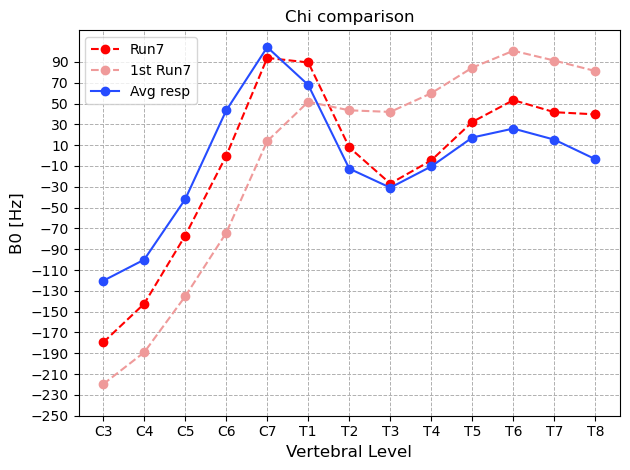

In [121]:
# We already have the cervical level and measured, 
# Copy the last (or any) fm metric name from SCT result

#final_dmod = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics\metrics_sim_fm_tr_-14_0_l_-0_277_Hz.csv")
final_dmod = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run2/metrics_sim_fm_tr_-9_0_l_-0_443_Hz.csv")

dmod_sim_vert_values = final_dmod["WA()"]
dmod_sim_vert_values = dmod_sim_vert_values[::-1]

vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8'] # From 3 to 15


#plt.plot(vertebrae_levels, dmod_b0meas_vert_values, marker = 'x', linestyle = '-', label = "Measured Exp", color = "#ff4900") 
#plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = "Run1", color = "#33C3FF") 
#plt.plot(vertebrae_levels, run6_values, marker = 'o', linestyle = '--', label = "Run6", color = "#FBC02D") 
plt.plot(vertebrae_levels, run7_values, marker = 'o', linestyle = '--', label = "Run7", color = "red") 
plt.plot(vertebrae_levels, first_run7_vals, marker = 'o', linestyle = '--', label = "1st Run7", color = "#EF9A9A") 
#plt.plot(vertebrae_levels, run4_last_iter_vals, marker = 'o', linestyle = '--', label = "Run4", color = "#81C784") 
plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 

# Adding expiration and inspiration measured values
#plt.plot(vertebrae_levels, exp_metrics_data_comp, marker = 'o', linestyle = '-', label = "Expiration B0 measured", color = "#ff4900")
#plt.plot(vertebrae_levels, insp_metrics_data_comp, marker = 'o', linestyle = '-', label = "Inspiration B0 measured", color = "#ffad00")
#plt.plot(vertebrae_levels, avg_respiration, marker = 'o', linestyle = ':', label = "Avg respiratin B0 meas", color = "#264cff")
plt.title("Chi comparison")
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()

yticks = range(-250, 101, 20) 
plt.yticks(yticks)


# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()

In [2]:
dir ()

['In',
 'Out',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__vsc_ipynb_file__',
 '_dh',
 '_exit_code',
 '_i',
 '_i1',
 '_i2',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'exit',
 'get_ipython',
 'open',
 'quit']